# Hydrodynamic Simulation Setup
Configure the individual loop simulations

In [1]:
import os
import warnings
import multiprocessing
import subprocess
import random
warnings.filterwarnings('ignore')

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,splrep,splev
from sunpy.map import Map
import astropy.units as u
import astropy.constants as const
import sunpy.sun.constants as sun_const
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.model_ext import EbtelInterface

%matplotlib inline

 using cli
 using CLI for selections
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/ChiantiPy/tools/data.py", line 22, in <module>
    xuvtop = os.environ['XUVTOP']
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/os.py", line 725, in __getitem__
    raise KeyError(key) from None
KeyError: 'XUVTOP'



* "Random nanoflare" model where each loop is hit once at some random point on the interval $[0,t_{total}]$
* Use small $t_{total}=5000$ s
* Use spatially-varying EBTEL model

In [2]:
field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/nsci_image_contest/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-10-29 00:32:02,675 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-29 00:32:02,675 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-10-29 00:32:02,676 Parameters: domain_left_edge          = [ -2.07156627e+10  -1.35997327e+10   9.49280088e+08]
yt : [INFO     ] 2017-10-29 00:32:02,677 Parameters: domain_right_edge         = [  2.53314633e+10   2.53742118e+10   4.65147243e+10]
yt : [INFO     ] 2017-10-29 00:32:02,677 Parameters: cosmological_simulation   = 0.0


## Heating Model

Setup a heating model where each loop is heating exactly once for 200 s beginning at some random time during the total 5000 s simulation time

In [3]:
class RandomNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = 1
        start_time = np.random.uniform(low=0,high=self.base_config['total_time'])
        max_energy = (self.heating_options['stress_level']*loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude':[max_energy/(self.heating_options['duration']/2.)],
                'rise_start':[start_time],
                'rise_end':[start_time+self.heating_options['duration']/2],
                'decay_start':[start_time+self.heating_options['duration']/2],
                'decay_end':[start_time+self.heating_options['duration']]}

In [4]:
heating_options = {
    'duration':200.0,
    'stress_level':0.1,
}

In [5]:
heating_model = RandomNanoflares(heating_options)

## Model Interface

In [6]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 100.0

In [ ]:
class EbtelSpatialVariations(EbtelInterface):
    
    def load_results(self, loop):
        # load results
        tmp = np.loadtxt(loop.hydro_configuration['output_filename'])
        time = tmp[:,0]*u.s
        temperature_electron = tmp[:,1]*u.K
        temperature_ion = tmp[:,2]*u.K
        density = tmp[:,3]*(u.cm**(-3))
        velocity = tmp[:,-2]*u.cm/u.s
        
        # calculate some constants
        c2 = 0.9
        c3 = 0.6
        h_to_he = loop.hydro_configuration['helium_to_hydrogen_ratio']
        z_avg = (1.0 + 2.0*h_to_he)/(1.0 + h_to_he)
        kB_correction = (1.0 + 1.0/z_avg)/2.0
        mi_correction = (1.0 + 4.0*h_to_he)/(2.0 + 3.0*h_to_he)*2.0*kB_correction
        mi = const.m_p.cgs*mi_correction
        g0 = sun_const.surface_gravity.cgs/u.s
        r0 = sun_const.radius.cgs
        
        # find apex, average, and TR points
        sparse_field_aligned_coordinate = np.array([loop.field_aligned_coordinate[0].value,
                                                    0.05*loop.full_length.value,
                                                    0.2*loop.full_length.value,
                                                    loop.field_aligned_coordinate[np.argmax(loop.coordinates[:,2])].value,
                                                    0.8*loop.full_length.value,
                                                    0.95*loop.full_length.value,
                                                    loop.field_aligned_coordinate[-1].value])
 
        # temperature
        ## electron
        temperature_0 = c3/c2*temperature_electron
        temperature_a = temperature_electron/c2
        temperature_chromosphere = 1e4*np.ones(temperature_electron.shape)
        sparse_temperature = np.vstack((temperature_chromosphere,temperature_0,
                                        temperature_electron,temperature_a,temperature_electron,
                                        temperature_0,temperature_chromosphere)).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_temperature,kind=2,axis=1)
        temperature_electron_interp = f(loop.field_aligned_coordinate)*temperature_electron.unit
        ## ion
        temperature_0 = c3/c2*temperature_ion
        temperature_a = temperature_ion/c2
        sparse_temperature = np.vstack((temperature_chromosphere,temperature_0,
                                        temperature_ion,temperature_a,temperature_ion,
                                        temperature_0,temperature_chromosphere)).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_temperature,kind=2,axis=1)
        temperature_ion_interp = f(loop.field_aligned_coordinate)*temperature_ion.unit
        
        # velocity
        sparse_velocity = np.vstack((np.zeros(velocity.shape),velocity,velocity,
                                     np.zeros(velocity.shape),
                                    -velocity,-velocity,np.zeros(velocity.shape))).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_velocity,kind='cubic',axis=1)
        velocity_interp = f(loop.field_aligned_coordinate)*velocity.unit
        
        scale_height = const.k_B.cgs*(temperature_electron_interp + temperature_ion_interp)/mi/g0
        
        # density
        density_chromosphere = 1e11*np.ones(density.shape)
        integral_0 = self._spatial_integral(sparse_field_aligned_coordinate[1],
                                             loop.coordinates[:,2].value + sun_const.radius.cgs.value,
                                             loop.field_aligned_coordinate.value,scale_height.value)
        density_0 = c2/c3*density*np.exp((r0.value**2)*integral_0)
        integral_a = self._spatial_integral(sparse_field_aligned_coordinate[3],
                                             loop.coordinates[:,2].value + sun_const.radius.cgs.value,
                                             loop.field_aligned_coordinate.value,scale_height.value)
        density_a = c3*density_0*np.exp(-(r0.value**2)*integral_a)
        sparse_density = np.vstack((density_chromosphere,density_0,
                                    density,density_a,density,
                                    density_0,density_chromosphere)).T
        f = interp1d(sparse_field_aligned_coordinate,sparse_density,kind=1,axis=1)
        density_interp = f(loop.field_aligned_coordinate)*density.unit
        
        return time,temperature_electron_interp,temperature_ion_interp,density_interp,velocity_interp
        
        
    def _spatial_integral(self,s_bound,z,s,scale_height):
        i_range = np.where(s<=s_bound)[0]
        if s[i_range].shape[0] == 1:
            i_range = np.array([i_range[0],i_range[0]+1])
        dz_ds = np.gradient(z[i_range],np.gradient(s[i_range]))
        return np.trapz((z[i_range])**(-2)*dz_ds/scale_height[:,i_range],s[i_range],axis=1)

In [7]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/nsci_image_contest/hydro_config/',
                                 '/storage-home/w/wtb2/data/nsci_image_contest/hydro_results/')

## Run Simulation

In [8]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [9]:
pool = multiprocessing.Pool()

In [10]:
field.configure_loop_simulations(ebtel_interface)

In [11]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [12]:
pool.close()

In [13]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/nsci_image_contest/loop_parameters.h5')

In [ ]:
print(field.loops[0].ion_temperature)

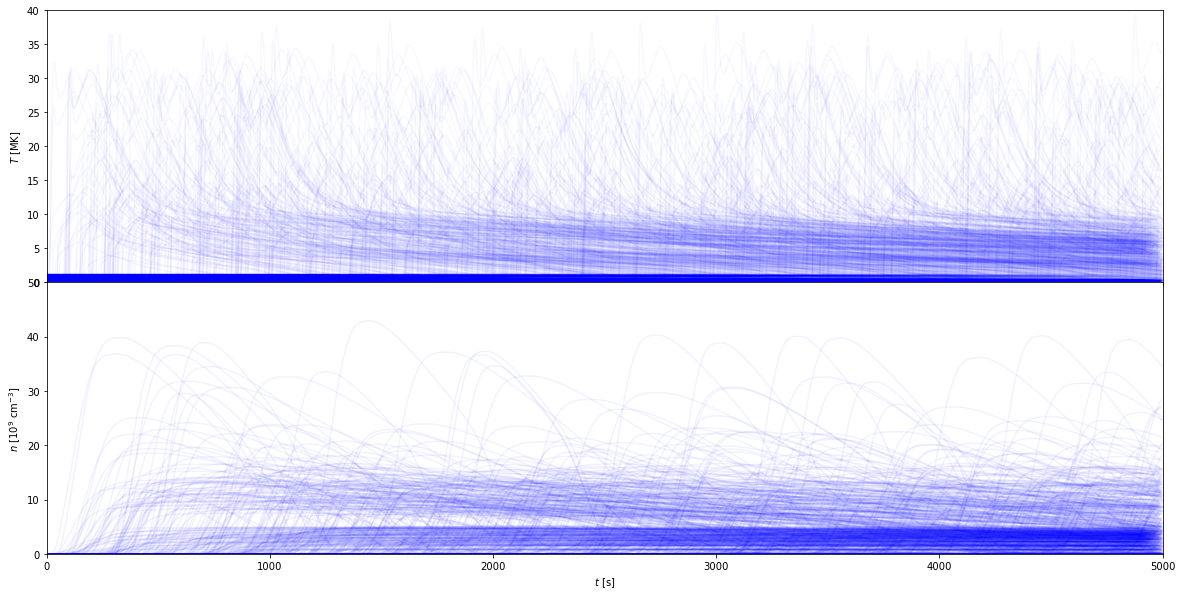

In [15]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::10]:
    axes[0].plot(loop.time,np.max(loop.electron_temperature.to(u.MK),axis=1),color='b',alpha=0.03)
    #axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='r',alpha=0.03)
    axes[1].plot(loop.time,np.mean(loop.density,axis=1)/1e9,color='b',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylim([0,40])
axes[1].set_ylim([0,50])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [17]:
field.save('/storage-home/w/wtb2/data/nsci_image_contest/field_checkpoint/')